#**Connecting to the drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets

# **To download the data set from kaggle**

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download')
# sdlpkmrmkkml
# 91b742aa9b01dc96ac5940ea43212cdc

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sdlpkmrmkkml
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images


# **Printing the GPU**

In [4]:
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **To know the number of images in Training the Dataset**

In [6]:
data = tf.keras.utils.image_dataset_from_directory('/content/cifake-real-and-ai-generated-synthetic-images/train', image_size=(32, 32))

Found 100000 files belonging to 2 classes.


#**Visualizing of sample set of images**

In [7]:
import matplotlib.pyplot as plt

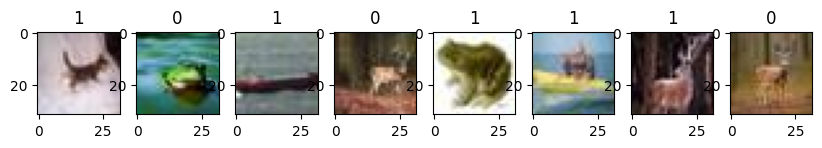

In [8]:
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
# The batch size is automatically set to 32 in image_dataset_from_directory()
print(f"Number of images in each batch: {len(batch[0])}")

Number of images in each batch: 32


# **Preprocessing the Dataset**

In [10]:
data = data.map(lambda x, y : (x/255, y))

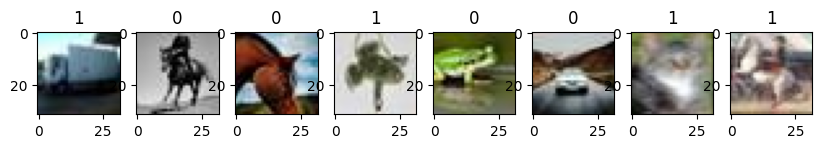

In [11]:
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

#**Splitting Data to Train, Test, Validation**

In [12]:
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print("Train: ",len(train))
print("Test: ", len(test))
print("Val: ",len(cv))

Train:  2187
Test:  313
Val:  625


In [13]:
print("Number of images in train: ",(len(train))*32)
print("Number of images in Val: ",(len(cv))*32)
print("Number of images in test: ",(len(test))*32)
print("Total number of images: ",(len(train)+len(cv)+len(test))*32)

Number of images in train:  69984
Number of images in Val:  20000
Number of images in test:  10016
Total number of images:  100000


#**Model Building**

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Adj

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# Overview of the Model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,305 (92.11 MB)

 Trainable params: 24,092,673 (91.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [18]:
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# **Data Augumentation**

In [19]:
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y
train_augmented = data.map(augment_data)

#**Model Training**

In [20]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_augmented, validation_data=cv, epochs=10, callbacks=[lr_schedule, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 184s 40ms/step - accuracy: 0.8334 - loss: 0.3883 - val_accuracy: 0.8730 - val_loss: 0.3342 - learning_rate: 9.5000e-04
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 109s 35ms/step - accuracy: 0.9110 - loss: 0.2278 - val_accuracy: 0.8956 - val_loss: 0.2706 - learning_rate: 9.0250e-04
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 111s 36ms/step - accuracy: 0.9220 - loss: 0.2017 - val_accuracy: 0.9114 - val_loss: 0.2299 - learning_rate: 8.5737e-04
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 137s 34ms/step - accuracy: 0.9232 - loss: 0.2007 - val_accuracy: 0.9377 - val_loss: 0.1617 - learning_rate: 8.1451e-04
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - accuracy: 0.9373 - loss: 0.1652 - val_accuracy: 0.9215 - val_loss: 0.1954 - learning_rate: 7.7378e-04
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9332 - loss: 0.1722 - val_accuracy: 0.9287 - val_loss: 0.1794 - learning_rate: 7.3509e-04
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━

#**Plotting Model Accuracy & Loss**

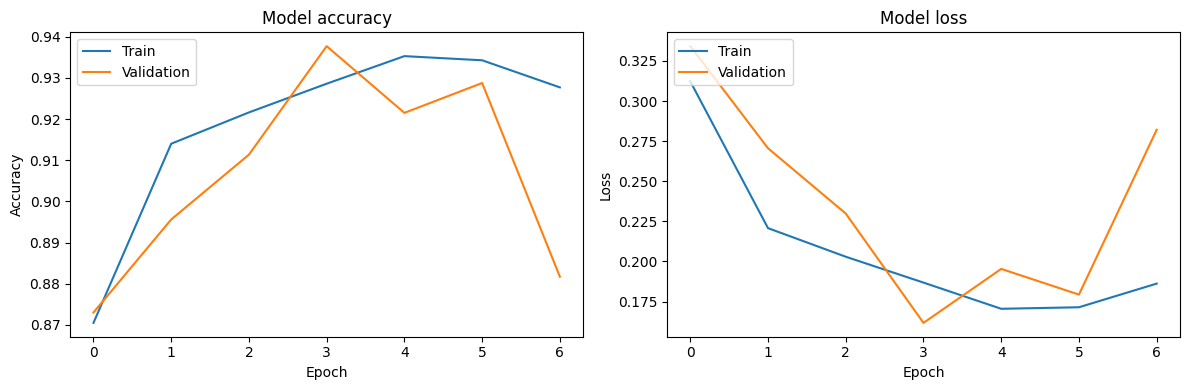

In [21]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

#**Precision, Recall & Accuracy**

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [24]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9132471680641174, Recall: 0.9746050834655762, Accuracy: 0.9410942196846008


**Save & Loaded The Mode**

In [25]:
model.save("Model.keras")

#**Model Prediction On Any Single Image**

In [26]:
import cv2

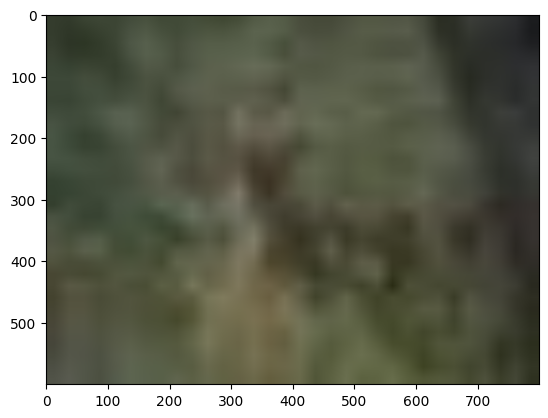

In [27]:
image_path = '/content/cifake-real-and-ai-generated-synthetic-images/train/REAL/0001 (5).jpg'
try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, (800, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [28]:
import numpy as np

In [29]:
resize = tf.image.resize(img, (32, 32))
y_pred = model.predict(np.expand_dims(resize/255, 0))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.9613335]], dtype=float32)

In [30]:
if y_pred > 0.5:
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: REAL


#**Classification Report & Confusion Matrix**

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

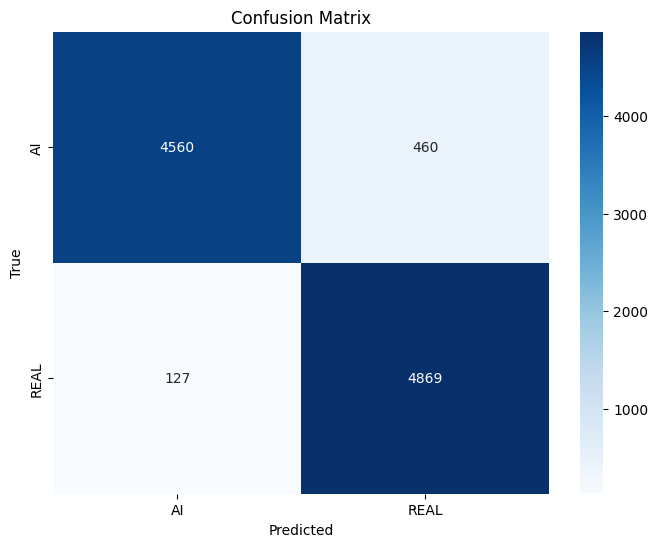

Classification Report:
               precision    recall  f1-score   support

          AI       0.97      0.91      0.94      5020
        REAL       0.91      0.97      0.94      4996

    accuracy                           0.94     10016
   macro avg       0.94      0.94      0.94     10016
weighted avg       0.94      0.94      0.94     10016



In [32]:
# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)